In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 样本

## 样本生成
用于生成（0,1]间的随机数  
缺点：不能很好的控制各亚组的样本数量

In [2]:
m0=3
N=500
P=2
M=3#真实的亚组数目
tp=0.005#惩罚系数
Ca=1#惩罚系数
weight=[ 1/3 , 1/3 ,1/3 ]#真实权重
mean=[-2 ,  0.4 , 2.5]#真实均值
covs=[0.9 , 1  , 0.9]#真实标准差
Theta=np.array([weight,mean,covs])
Theta#混合高斯分布的参数，mean越靠近且离散程度越大，区分的难度越大

array([[ 0.33333333,  0.33333333,  0.33333333],
       [-2.        ,  0.4       ,  2.5       ],
       [ 0.9       ,  1.        ,  0.9       ]])

In [3]:
#定义各组样本量的界点
subnum=np.zeros(M-1)
subnum[0]=N*weight[0]
weight1=np.zeros(M+1)
weight1[0]=0
weight1[M]=1
for i in range(1,M-1):
    subnum[i]=subnum[i-1]+N*weight[i]
for i in range(1,M):
    weight1[i]=np.sum(weight[:i])

In [4]:
np.random.seed(45)
mu=np.array([0,0])
cov=np.array([[2,1],[1,2]])
X=np.random.multivariate_normal(mu,cov,N,check_valid='raise')
betat=np.random.uniform(0,1,P)#真实的斜率
betat

array([0.6465484 , 0.94609322])

In [5]:
np.random.seed(54)
Y=np.zeros((N,2))#随机生成样本
for i in range(N):
    a=np.random.rand()
    for j in range(M):
        if a>=weight1[j] and a<=weight1[j+1]:
            Y[i,0]=np.dot(X[i],betat)+np.random.normal(Theta[1,j],Theta[2,j])
            Y[i,1]=j

## 展示样本

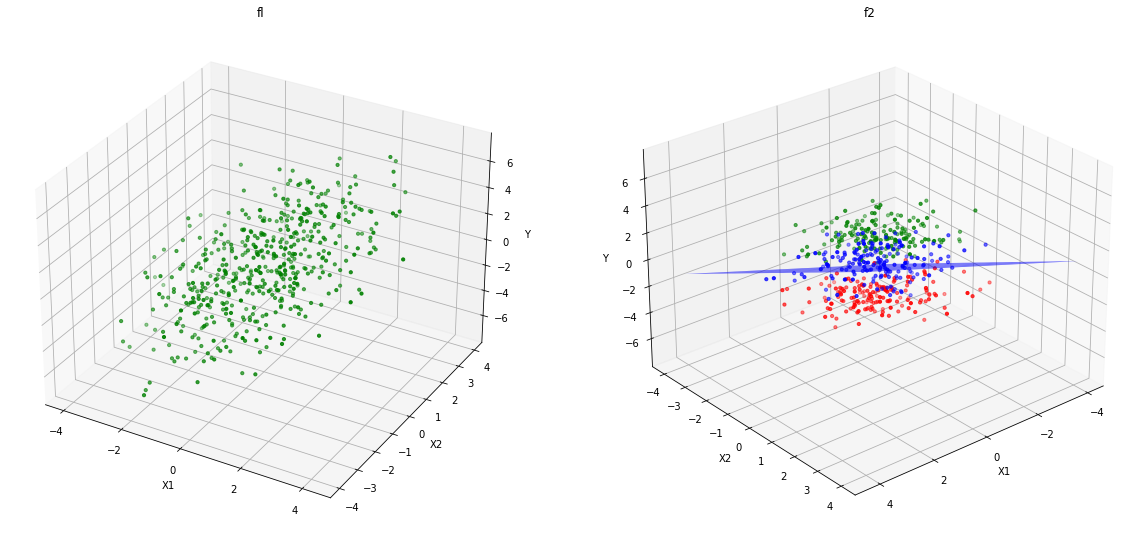

In [6]:
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'cyan', 4:'brown',5:'burlywood'}

fig = plt.figure(figsize=(20,10))

xm = np.linspace(-4,4,10)
ym = np.linspace(-4,4,10)
Xm, Ym = np.meshgrid(xm, ym)

ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(X[:,0], X[:,1],Y[:,0] ,c = 'g', s = 10)
ax1.set_zlabel('Y')  # 坐标轴
ax1.set_ylabel('X2')
ax1.set_xlabel('X1')
ax1.set_title('fl')

ax2 = fig.add_subplot(122, projection='3d')
for g in np.unique(Y[:,1]):
    ix = np.where(Y[:,1] == g)
    ax2.scatter(X[ix,0], X[ix,1],Y[ix,0] ,c = cdict[g], label = g, s = 10)

ax2.plot_surface(Xm,Ym,Z=betat[0]*Xm+betat[1]*Ym, color='b',alpha=0.6,label='True beta')
ax2.set_zlabel('Y')  # 坐标轴
ax2.set_ylabel('X2')
ax2.set_xlabel('X1')
ax2.view_init(elev=27,azim=50)
ax2.set_title('f2')
plt.show()

# H0m=m0 v.s. H1:m>m0 下的参数估计

In [7]:
def normal(x,theta):
    mu=theta[0]
    s=theta[1]#标准差
    result=(1/(np.sqrt(2*np.pi)*s))*np.exp(-1*(x-mu)**2/(2*s**2))
    return result

def mixnormal(x,theta):
    m=theta.shape[1]
    result=0
    for i in range(m):
        result+=theta[0,i]*normal(x,theta[1:,i])
    return result

def Lih(X,theta):
    num=X.shape[0]
    C=theta.shape[1]
    Ga=np.zeros((num,C))
    c=np.zeros(C)

    for j in range(num):#响应度
        for k in range(C):
            c[k]=theta[0,k]*normal(X[j],theta[1:,k])
        Ga[j]=c/np.sum(c)

    return Ga

In [8]:
def ps(x,y,an=0.25):#对方差的惩罚函数
    z=-an*(np.log(x**2/y**2)+(y**2/x**2)-1)
    return z

def pa(α):#对系数的惩罚函数
    z=Ca*np.log(1-abs(1-2*α))
    return z

## H0下的最大惩罚似然计算

In [9]:
'''
原假设下的惩罚对数似然,这里只对方差惩罚，不对α惩罚
因为H0为m=1时有惩罚似然最大中在α=0.5取到，自然设置α=0.5
H0为m=m0>=2时，有充分的理由认为不会发生不可识别问题，即αh(h=1,2,...,m0)不会落在界点上
'''
def pl0(data,theta,tp):
    n=data.shape[0]
    m=theta.shape[1]
    y=np.zeros(n)
    ssvar=np.var(data)
    a=0
    for h in range(m):
        a+=ps(theta[2,h],ssvar,tp)
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [10]:
def ECMforH0(Xs,Y,betaold,thetaold,theta0):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=thetaold.shape[1]
    d=np.zeros(C)
    thetanext=np.zeros((3,C))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)

    datanew=Y-np.dot(Xs,betanew.T)
    for k in range(C):#更新参数
        d[k]=np.sum(L0[:,k])
        thetanext[0,k]=d[k]/num
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


In [11]:
def iterECMforH0(Xs,Y,beta0,theta0,N=1000,stopbyN= False,ε=0.0005):
    T0=[beta0,theta0]
    exitflag=False
    c=0
    if stopbyN == True:
        for i in range(N):
            a=T0
            T0=ECMforH0(Xs,Y,T0[0],T0[1],theta0)
            c=np.linalg.norm(T0[1][0]-a[1][0])

    else:
        for i in range(N):
            if exitflag == True:
                break
            a=T0
            T0=ECMforH0(Xs,Y,T0[0],T0[1],theta0)
            if (np.linalg.norm(T0[1][0]-a[1][0])/(np.linalg.norm(a[1][0])+0.0001)) <= ε:
                c=np.linalg.norm(T0[0]-a[0])
                exitflag = True

    return T0,c,i

### 获取H0下的最优估计

#### beta的初值

In [12]:
#beta的初值根据对全体样本做最小二乘确定
model = LinearRegression() # 构建线性模型
model.fit(X, Y[:,0]) # 自变量在前，因变量在后
beta0 = model.coef_ # 斜率
intercept = model.intercept_ # 截距
print(betat,'\n',model.coef_, model.intercept_) # 输出斜率和截距

[0.6465484  0.94609322] 
 [0.55281562 0.94410737] 0.2608601543474708


#### 其他参数的初值选取

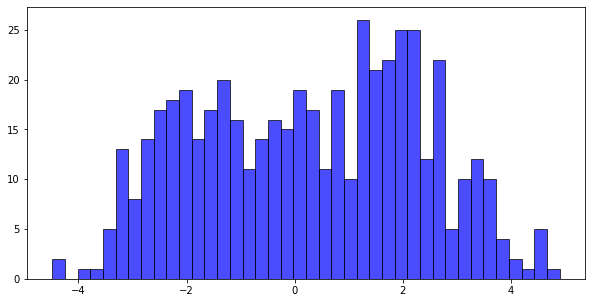

In [13]:
data0=np.zeros(N)
for i in range(N):
    data0[i]=Y[i,0]-np.dot(X[i],beta0)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot()
ax1.hist(data0, bins=40,  facecolor="blue", edgecolor="black", alpha=0.7)
plt.show()

#### H0:m=1

In [14]:
smean=np.mean(data0)
sstd=np.std(data0)
ssvar=np.var(data0)
stheta0=np.array([[0.5],[smean],[sstd]])
stheta0#样本均值与样本的标准差

array([[0.5       ],
       [0.26086015],
       [2.05473606]])

In [15]:
Theta

array([[ 0.33333333,  0.33333333,  0.33333333],
       [-2.        ,  0.4       ,  2.5       ],
       [ 0.9       ,  1.        ,  0.9       ]])

#### H0:m>=2（待改进）

In [16]:
weight0=[0.3,0.4,0.3]
mean0=[-2,0.5,2]
#分位数定均值初值
covs0=[1,1,1]
theta0=np.array([weight0,mean0,covs0])

In [17]:
print(' 初值:\n','β初值:',beta0,'\n','参数初值:\n',theta0,'\n','-'*50,'\n','真值：\n','β真值:',betat,'\n','参数真值:\n',Theta)

 初值:
 β初值: [0.55281562 0.94410737] 
 参数初值:
 [[ 0.3  0.4  0.3]
 [-2.   0.5  2. ]
 [ 1.   1.   1. ]] 
 -------------------------------------------------- 
 真值：
 β真值: [0.6465484  0.94609322] 
 参数真值:
 [[ 0.33333333  0.33333333  0.33333333]
 [-2.          0.4         2.5       ]
 [ 0.9         1.          0.9       ]]


In [18]:
result=iterECMforH0(X,Y[:,0],betat,Theta,30,True)
print(' 收敛值:\n','β收敛值:',result[0][0],'\n','参数收敛值:\n',result[0][1],'\n最后两次迭代间的‘差距’\n',result[1],'迭代停止次数：',result[2])

 收敛值:
 β收敛值: [0.55658931 0.94138035] 
 参数收敛值:
 [[ 0.32049104  0.33130647  0.34820249]
 [-2.06263007  0.40794808  2.25858783]
 [ 0.86897548  1.19182024  1.04785677]] 
最后两次迭代间的‘差距’
 0.000862089888088584 迭代停止次数： 29


In [19]:
betaH0=result[0][0]
thetaH0=result[0][1]

In [20]:
data2=np.zeros(N)
for i in range(N):
    data2[i]=Y[i,0]-np.dot(X[i],betaH0)

In [21]:
#H0下的惩罚似然
sr01=pl0(data2,result[0][1],tp)
sr01

-1036.2798850825593

In [22]:
datat=np.zeros(N)
for i in range(N):
    datat[i]=Y[i,0]-np.dot(X[i],betat)

In [ ]:
np.savetxt("C:/Users/Administrator/Desktop/datat.csv",datat,delimiter=',')

In [23]:
pl0(datat,Theta,tp)

-1040.1417723865245

## H1下的似然计算

#混合正态的惩罚联合对数似然,注意这里的x为Yi-Xi.T*beta,k表示第k个初始值
def pl1(k,data,theta,th0,C=1):
    n=data.shape[0]
    m=th0.shape[1]
    y=np.zeros(n)
    a=0
    for h in range(m):
        a+=ps(theta[2,(2*h)],th0[2,h],tp)+ps(theta[2,(2*h+1)],th0[2,h],tp)+pa(theta[0,2*h],C)+pa(theta[k,(2*h+1)],C)
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [24]:
#混合正态的惩罚联合对数似然,注意这里的x为Yi-Xi.T*beta
def pl1(k,data,theta,th0):
    n=data.shape[0]
    m=th0.shape[1]
    y=np.zeros(n)
    a=0
    for h in range(m):
        a+=ps(theta[2,(2*h)],th0[2,h],tp)+ps(theta[2,(2*h+1)],th0[2,h],tp)+pa(aa[k,h])
    for i in range(n):
        y[i]=np.log(mixnormal(data[i],theta))
    z=np.sum(y)+a
    return z

In [25]:
#用来对固定权重迭代参数的ECM，不更新权重
def ECMff(Xs,Y,we,betaold,thetaold,theta0):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=int(thetaold.shape[1])
    C0=int(C/2)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    thetanext0=np.zeros((3,C0))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)
    datanew=Y-np.dot(Xs,betanew.T)
    '''
    以上为更新beta的部分，下面为更新混合正态的部分
    '''
    for l in range(C0):
        d[2*l]=np.sum(L0[:,2*l])
        d[2*l+1]=np.sum(L0[:,2*l+1])
        thetanext0[0,l]=(d[2*l]+d[2*l+1])/num
        thetanext[0,2*l]=thetanext0[0,l]*we[l]
        thetanext[0,2*l+1]=thetanext0[0,l]*(1-we[l])

    for k in range(C):#更新参数
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


In [26]:
def iterECMff(Xs,Y,beta0,theta0,N=1000,stopbyN= False,ε=0.005):
    C0=int(theta0.shape[1]/2)
    we=np.zeros(C0)
    for l in range(C0):
        we[l]=(theta0[0,2*l])/(theta0[0,2*l]+theta0[0,2*l+1])
    T0=[beta0,theta0]
    exitflag=False
    c=0
    if stopbyN == True:
        for i in range(N):
            a=T0
            T0=ECMff(Xs,Y,we,T0[0],T0[1],theta0)

    else:
        for i in range(N):
            if exitflag == True:
                break
            a=T0
            T0=ECMff(Xs,Y,we,T0[0],T0[1],theta0)
            if (np.linalg.norm(T0[0]-a[0])/(np.linalg.norm(a[0])+0.001)) <= ε:
                c=np.linalg.norm(T0[0]-a[0])
                exitflag = True

    return T0,c,i

In [27]:
#对于H1下的一次迭代的参数估计
def ECMforH1(Xs,Y,betaold,thetaold,theta0,s=1):
    P=Xs.shape[1]
    num=Xs.shape[0]
    data=Y-np.dot(Xs,betaold.T)
    L0=Lih(data,thetaold)
    C=int(thetaold.shape[1])
    C0=int(C/2)
    d=np.zeros(C)
    thetanext=np.zeros((3,C))
    thetanext0=np.zeros((3,C0))

    ai=np.zeros(num)
    bi=np.zeros(num)
    for i in range (num):
        for h in range(C):
            bi[i]+=(L0[i,h])/((thetaold[2,h])**2)
            ai[i]+=((L0[i,h])*((Y[i]-thetaold[1,h])))/((thetaold[2,h])**2)

    xnew=np.zeros((num,P))
    for i in range(num):
        xnew[i]=Xs[i]*bi[i]

    betanew=np.dot(np.dot(np.linalg.inv(np.dot(xnew.T,Xs)),Xs.T),ai)
    datanew=Y-np.dot(Xs,betanew.T)
    '''
    以上为更新beta的部分，下面为更新混合正态的部分
    '''
    for l in range(C0):
        d[2*l]=np.sum(L0[:,2*l])
        d[2*l+1]=np.sum(L0[:,2*l+1])
        thetanext0[0,l]=(d[2*l]+d[2*l+1])/num
        if (d[2*l]/(d[2*l]+d[2*l+1])) <= 0.5:
            if (d[2*l]+Ca)/((d[2*l]+d[2*l+1])+Ca) <= 0.5:
                thetanext[0,2*l]=((d[2*l]+Ca)/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
                thetanext[0,2*l+1]=((d[2*l+1])/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
            else:
                thetanext[0,2*l]=0.5*thetanext0[0,l]
                thetanext[0,2*l+1]=0.5*thetanext0[0,l]
        else:
            if (d[2*l])/((d[2*l]+d[2*l+1])+Ca) > 0.5:
                thetanext[0,2*l]=((d[2*l])/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
                thetanext[0,2*l+1]=((d[2*l+1]+Ca)/((d[2*l]+d[2*l+1])+Ca))*thetanext0[0,l]
            else:
                thetanext[0,2*l]=0.5*thetanext0[0,l]
                thetanext[0,2*l+1]=0.5*thetanext0[0,l]

    for k in range(C):#更新参数
        thetanext[1,k]=np.dot(L0[:,k],datanew[:])/d[k]
        thetanext[2,k]=np.sqrt((np.dot(L0[:,k],(datanew[:]-thetanext[1,k])**2)+2*tp*theta0[2,k])/(d[k]+2*tp))#标准差

    return betanew,thetanext


In [28]:
def iterECMforH1(Xs,Y,beta0,theta0,N=1000,stopbyN= False,ε=0.005):
    T0=[beta0,theta0]
    exitflag=False
    c=0
    if stopbyN == True:
        for i in range(N):
            a=T0
            T0=ECMforH1(Xs,Y,T0[0],T0[1],theta0)

    else:
        for i in range(N):
            if exitflag == True:
                break
            a=T0
            T0=ECMforH1(Xs,Y,T0[0],T0[1],theta0)
            if (np.linalg.norm(T0[0]-a[0])/(np.linalg.norm(a[0])+0.001)) <= ε:
                c=np.linalg.norm(T0[0]-a[0])
                exitflag = True

    return T0,c,i

### step 0 设定不同的初值
m0个数组的排列问题  
当m0为确定的数时，只需要套m0个循环即可  
如果m0未知，无法用上述想法做了，可以将循环问题转为递归问题  
或者用查询的方法做

In [29]:
Weight=np.array([0.1,0.9,0.3,0.7,0.5])
Weight0=np.zeros((5**m0,2*m0))#H1下的初始权重
aa=np.zeros((5**m0,m0))

In [30]:
for i in range (5**m0):
    for j in range(m0):
        a=np.floor(i/(5**(m0-j-1)))
        if a>4:
            a=a-5*np.floor(a/5)
        b=int(a)
        aa[i,j]=Weight[b]
        Weight0[i,2*j]=Weight[b]*thetaH0[0,j]
        Weight0[i,2*j+1]=(1-Weight[b])*thetaH0[0,j]

### step 1 固定参数的不同初值下，分别选取使得惩罚似然达到最大的正态参数
（ECMff多次迭代即可）

In [31]:
Theta

array([[ 0.33333333,  0.33333333,  0.33333333],
       [-2.        ,  0.4       ,  2.5       ],
       [ 0.9       ,  1.        ,  0.9       ]])

In [32]:
thetaH0

array([[ 0.32049104,  0.33130647,  0.34820249],
       [-2.06263007,  0.40794808,  2.25858783],
       [ 0.86897548,  1.19182024,  1.04785677]])

In [33]:

Th=np.zeros((5**m0,3,2*m0))
Be=np.zeros((5**m0,P))
for i in range(5**m0):
    thetan=np.array((Weight0[i],[-2.5,-1.5,0,1,2,3],[0.5,0.5,0.5,0.5,0.5,0.5]))
    res=iterECMff(X,Y[:,0],betaH0,thetan,20,True)
    Th[i]=res[0][1]
    Be[i]=res[0][0]

'''
Th[i]表示第i个权重初值下的最佳参数初值  
Be[i]表示第i个权重初值下的最佳斜率初值  
以上均作为最早的初值参与迭代
'''

'\nTh[i]表示第i个权重初值下的最佳参数初值  \nBe[i]表示第i个权重初值下的最佳斜率初值  \n以上均作为最早的初值参与迭代\n'

### step 2 分别选定初始参数后的迭代（只需迭代几次）

In [34]:
rs=np.zeros(5**m0)
Th1=np.zeros((5**m0,3,2*m0))
Be1=np.zeros((5**m0,P))
for i in range(5**m0):
    res=iterECMforH1(X,Y[:,0],Be[i],Th[i],3,True)
    Th1[i]=res[0][1]
    Be1[i]=res[0][0]
    da=np.zeros(N)
    for j in range(N):
        da[j]=Y[j,0]-np.dot(X[j],Be1[i])
    rs[i]=pl1(i,da,Th1[i],thetaH0)

In [35]:
2*(rs-sr01)

array([-3.86658675, -4.9765947 , -1.29455366, -1.37759701, -0.07176745,
       -1.22966003, -5.13615421, -1.521914  , -1.99642208, -0.94669703,
       -1.56293282, -2.90255209,  0.63849204,  0.48609648,  1.76837923,
       -2.46148446, -3.01549138, -0.02000308,  0.08269297,  1.20709066,
       -1.28217771, -2.08178223,  1.09768493,  1.07145847,  2.27075519,
       -4.4061808 , -4.9710107 , -1.36240291, -1.22323024,  0.0125355 ,
       -3.53557533, -0.59954867, -0.8146354 , -0.24932031,  0.50692865,
       -1.0421595 , -1.70157692,  1.39364326,  1.28624693,  2.58440222,
       -0.80178946,  1.37842721,  1.68900509,  2.27875629,  3.05644737,
        0.34754096,  1.21557274,  2.80409893,  2.91302885,  4.03992344,
       -2.54924017, -3.50953451,  0.0977181 ,  0.08158682,  1.35895938,
        0.69722665, -2.91821493,  0.77948376,  0.20324978,  1.25249169,
        0.11488742, -1.06907519,  2.35996131,  2.21265429,  3.49865366,
       -0.26577369, -0.79576768,  2.18650956,  2.28739687,  3.41

In [36]:
np.max(2*(rs-sr01))

5.592671014931057

df	0.995	0.99	0.975	0.95	0.90	0.10	0.05	0.025	0.01	0.005
6	0.676	0.872	1.237	1.635	2.204	10.645	12.592	14.449	16.812	18.548

df	0.995	0.99	0.975	0.95	0.90	0.10	0.05	0.025	0.01	0.005
4	0.207	0.297	0.484	0.711	1.064	7.779	9.488	11.143	13.277	14.860

In [37]:
np.where(2*(rs-sr01)==np.max(2*(rs-sr01)))

(array([124], dtype=int64),)

In [38]:
betat,Theta

(array([0.6465484 , 0.94609322]),
 array([[ 0.33333333,  0.33333333,  0.33333333],
        [-2.        ,  0.4       ,  2.5       ],
        [ 0.9       ,  1.        ,  0.9       ]]))

In [39]:
betaH0,thetaH0

(array([0.55658931, 0.94138035]),
 array([[ 0.32049104,  0.33130647,  0.34820249],
        [-2.06263007,  0.40794808,  2.25858783],
        [ 0.86897548,  1.19182024,  1.04785677]]))

In [42]:
Be1[124],Th1[124]

(array([0.55218756, 0.94032795]),
 array([[ 0.18148837,  0.18148837,  0.15426708,  0.15426708,  0.16424455,
          0.16424455],
        [-2.56026881, -1.43950651, -0.05379746,  1.11806475,  1.96649466,
          3.04372462],
        [ 0.66925125,  0.59436156,  0.48552819,  0.55351647,  0.46530588,
          0.80800609]]))

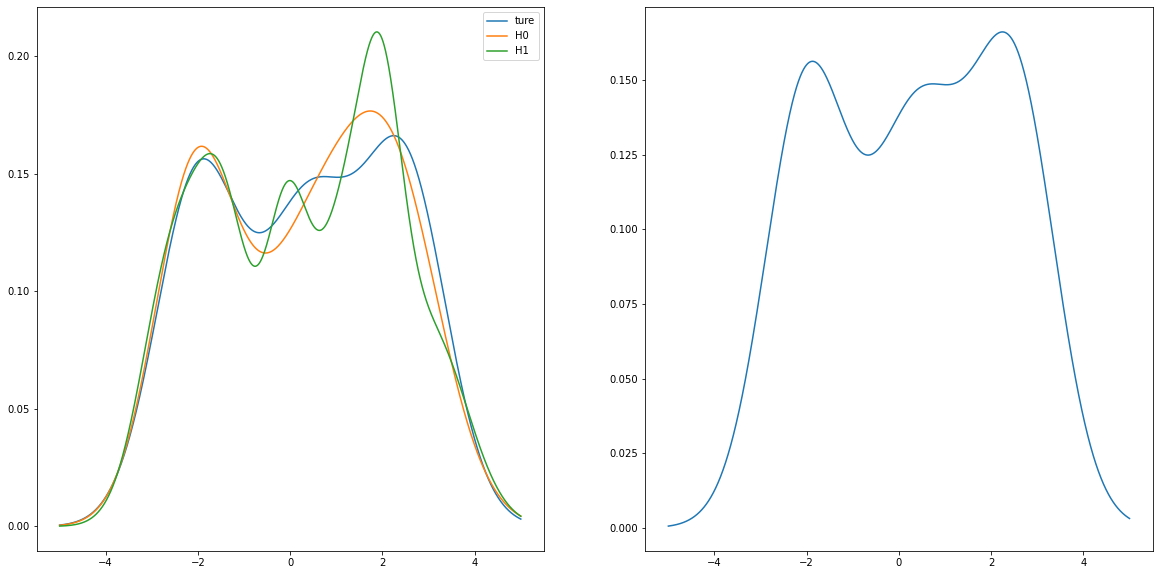

In [43]:
fig = plt.figure(figsize=(20,10))
x = np.linspace(-5,5,2000) # 从0到1，等分50分

c1 = mixnormal(x,Theta)
c2 = mixnormal(x,thetaH0)
c3 = mixnormal(x,Th1[124])

ax1 = fig.add_subplot(121)
ax1.plot(x,c1)
ax1.plot(x,c2)
ax1.plot(x,c3)
ax1.legend(['ture','H0','H1'])
ax2 = fig.add_subplot(122)
ax2.plot(x,c1)
plt.show()

### step 3
每次找出使得H1下惩罚似然达到最大的那个初始参数，计算对应的似然比统计量

# EM值计算

## ECM的迭代算法
```
def iterECM(Xs,Y,beta0,theta0,tp=0.002,N=1000,ε=0.005):
    T0=[beta0,theta0]
    for i in range(N):
        a=T0[0]
        T0=ECM(Xs,Y,T0[0],T0[1],theta0,tp)
        b=np.linalg.norm(T0[0]-a)
        '''
        if b<=ε:
            break
        '''
    return T0,b,i
```